<a href="https://colab.research.google.com/github/stealthyblacks/Traffic-Prediction-app/blob/main/Traffic_Congestion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enviroment Setup

In [ ]:
!pip install imbalanced-learn --quiet


#Importing Dependencies
---

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import holidays
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

# Import Datasets
---

In [ ]:
mobility_df = pd.read_csv("/content/smart_mobility_dataset.csv", parse_dates=["Timestamp"])



## Exploring The Data

In [ ]:
mobility_df.tail()

,Timestamp,Latitude,Longitude,Vehicle_Count,Traffic_Speed_kmh,Road_Occupancy_%,Traffic_Light_State,Weather_Condition,Accident_Report,Sentiment_Score,Ride_Sharing_Demand,Parking_Availability,Emission_Levels_g_km,Energy_Consumption_L_h,Traffic_Condition
4995,2024-03-18 08:15:00,40.604663,-73.831032,266,22.987611,12.670629,Green,Rain,0,0.698929,87,28,252.070807,7.511153,High
4996,2024-03-18 08:20:00,40.733790,-73.752213,20,75.736987,49.108556,Green,Snow,0,0.742800,5,0,203.563872,6.681980,Low
4997,2024-03-18 08:25:00,40.821354,-73.759376,43,59.492981,78.719110,Yellow,Clear,0,0.524574,94,16,71.660296,25.267246,Medium
4998,2024-03-18 08:30:00,40.772343,-73.836698,88,25.901119,64.690719,Yellow,Rain,0,-0.589902,73,5,442.692618,29.467326,Medium
4999,2024-03-18 08:35:00,40.756688,-73.849335,147,51.473769,28.048376,Green,Snow,0,0.569793,93,16,119.196815,25.065909,Medium


## Checking Data type

In [ ]:
mobility_df.dtypes

,0
Timestamp,datetime64[ns]
Latitude,float64
Longitude,float64
Vehicle_Count,int64
Traffic_Speed_kmh,float64
Road_Occupancy_%,float64
Traffic_Light_State,object
Weather_Condition,object
Accident_Report,int64
Sentiment_Score,float64


In [ ]:
mobility_df.columns

Index(['Timestamp', 'Latitude', 'Longitude', 'Vehicle_Count',
       'Traffic_Speed_kmh', 'Road_Occupancy_%', 'Traffic_Light_State',
       'Weather_Condition', 'Accident_Report', 'Sentiment_Score',
       'Ride_Sharing_Demand', 'Parking_Availability', 'Emission_Levels_g_km',
       'Energy_Consumption_L_h', 'Traffic_Condition'],
      dtype='object')

# Data Cleaning And Preprocessing.
---

## Droping Columns

In [ ]:
cols_to_drop = [
    'Sentiment_Score',
    'Ride_Sharing_Demand',
    'Parking_Availability',
    'Emission_Levels_g_km',
    'Energy_Consumption_L_h',
    'Latitude',
    'Longitude'

]
existing_cols_to_drop = [col for col in cols_to_drop if col in mobility_df.columns]
mobility_df.drop(columns=existing_cols_to_drop, inplace=True)
mobility_df.columns


Index(['Timestamp', 'Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%',
       'Traffic_Light_State', 'Weather_Condition', 'Accident_Report',
       'Traffic_Condition'],
      dtype='object')

## Checking for missing values.

In [ ]:
mobility_df.isnull().sum()

,0
Timestamp,0
Vehicle_Count,0
Traffic_Speed_kmh,0
Road_Occupancy_%,0
Traffic_Light_State,0
Weather_Condition,0
Accident_Report,0
Traffic_Condition,0


##Removing Duplicates.

In [ ]:
mobility_df.drop_duplicates(inplace=True)

In [ ]:
replace = mobility_df.loc[mobility_df['Weather_Condition'] == "Snow"].index
mobility_df.loc[replace, 'Weather_Condition'] = np.random.choice(['Rain', 'Fog'], size=len(replace))

In [ ]:
mobility_df.shape

(5000, 8)

## Selecting Features Based On Time Stamp

In [ ]:
mobility_df['Timestamp'] = pd.to_datetime(mobility_df['Timestamp'], dayfirst=True)
mobility_df['Hour'] = mobility_df['Timestamp'].dt.hour
mobility_df['DayOfWeek'] = mobility_df['Timestamp'].dt.day_name()
mobility_df['Date'] = mobility_df['Timestamp'].dt.date

In [ ]:
mobility_df["Hour"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

## Outliers

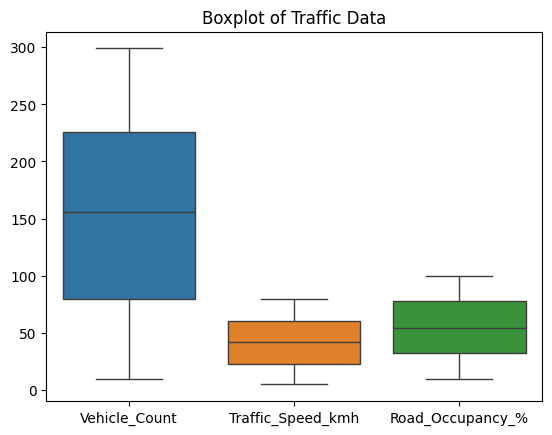

In [ ]:
sns.boxplot(data=mobility_df[['Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%']])
plt.title('Boxplot of Traffic Data')
plt.show()

# Exploratory Data Analysis

---



In [ ]:
# Save the DataFrame with the new features to a CSV file
mobility_df.to_csv('/content/mobility_with_new_features.csv', index=False)

# Confirm that the file is saved
print("Data saved with new features!")


Data saved with new features!


In [ ]:
from google.colab import files

# Download the saved CSV file
files.download('/content/mobility_with_new_features.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mobility_df.columns

Index(['Timestamp', 'Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%',
       'Traffic_Light_State', 'Weather_Condition', 'Accident_Report',
       'Traffic_Condition', 'Hour', 'DayOfWeek', 'Date'],
      dtype='object')

## Peek Hours

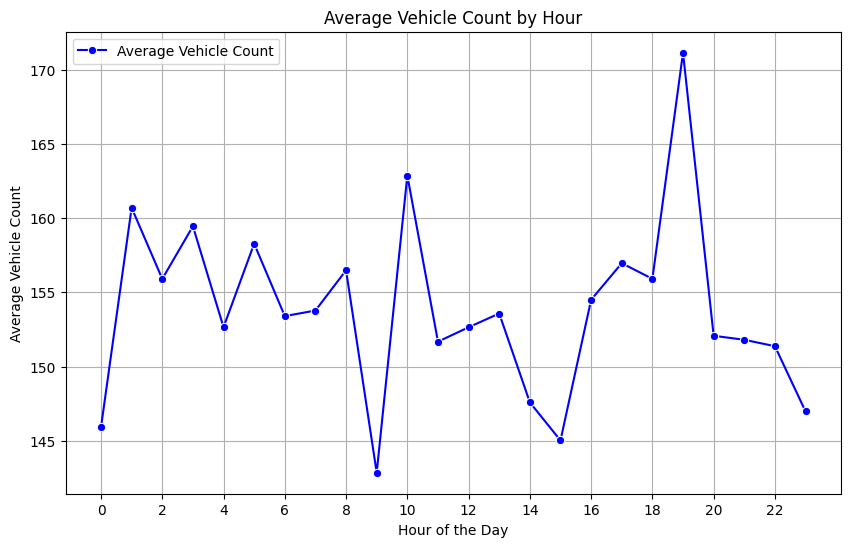

In [ ]:
peak_hours = mobility_df.groupby('Hour')['Vehicle_Count'].mean().reset_index()

peak_hours = peak_hours.sort_values(by='Vehicle_Count', ascending=False)

plt.figure(figsize=(10,6))
sns.lineplot(x='Hour', y='Vehicle_Count', data=peak_hours, marker='o', color='b', label='Average Vehicle Count')

plt.title('Average Vehicle Count by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Vehicle Count')
plt.xticks(range(0 , 24 , 2))
plt.grid(True)
plt.show()


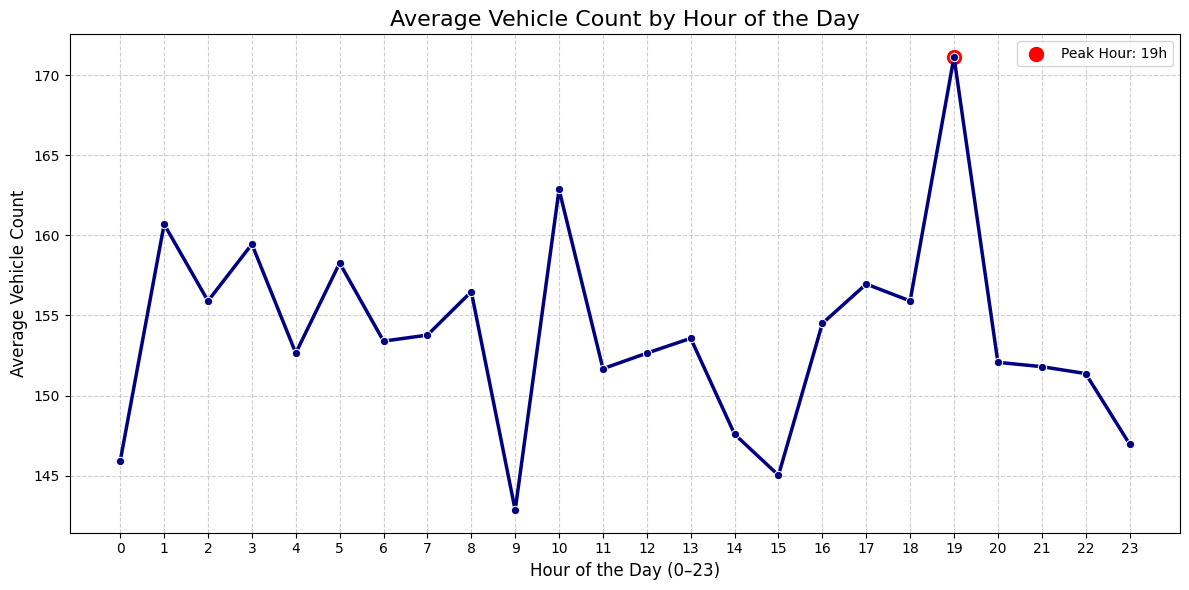

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Step 1: Calculate average vehicle count per hour
hourly_avg = mobility_df.groupby('Hour')['Vehicle_Count'].mean().reset_index()

# Step 2: Sort by average vehicle count (descending)
hourly_avg_sorted = hourly_avg.sort_values(by='Vehicle_Count', ascending=False)

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='Vehicle_Count', data=hourly_avg, marker='o', color='navy', linewidth=2.5)

# Highlight peak hour(s)
peak_hour = hourly_avg_sorted.iloc[0]
plt.scatter(peak_hour['Hour'], peak_hour['Vehicle_Count'], color='red', s=100, label=f"Peak Hour: {int(peak_hour['Hour'])}h")

# Plot formatting
plt.title('Average Vehicle Count by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (0–23)', fontsize=12)
plt.ylabel('Average Vehicle Count', fontsize=12)
plt.xticks(range(0, 24, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Optional: Format y-axis with commas if large numbers
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


## The Busiest day of the Week.

In [ ]:
mobility_df["DayOfWeek"].unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

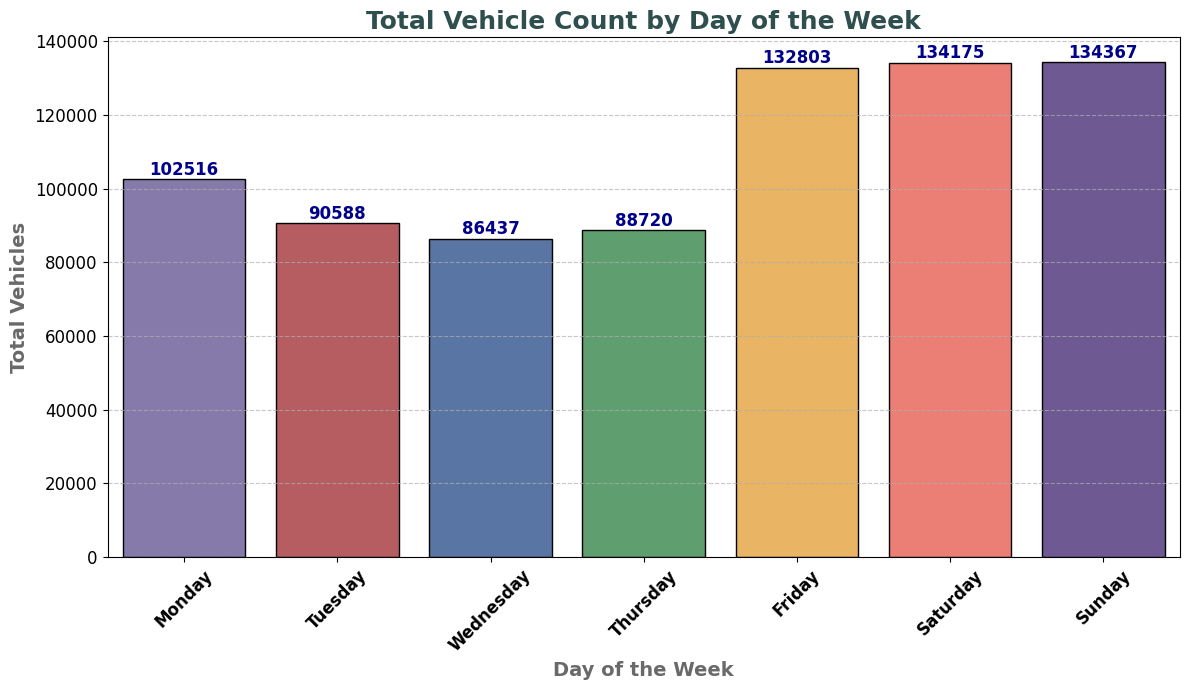

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by DayOfWeek and sum Vehicle_Count
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
busiest_days = mobility_df.groupby('DayOfWeek', observed=False)['Vehicle_Count'].sum().reindex(day_order)

# Define custom colors for each day
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#FFB94E', '#FF6F61', '#6B4F9C']

# Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=busiest_days.index, y=busiest_days.values, hue=busiest_days ,palette=colors, edgecolor='black')

# Annotate bars with total vehicle count
for index, value in enumerate(busiest_days.values):
    ax.text(index, value + 100, f'{int(value)}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='darkblue')

# Add gridlines, style improvements
plt.title("Total Vehicle Count by Day of the Week", fontsize=18, fontweight='bold', color='darkslategray')
plt.ylabel("Total Vehicles", fontsize=14, fontweight='bold', color='dimgray')
plt.xlabel("Day of the Week", fontsize=14, fontweight='bold', color='dimgray')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Customize the gridlines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove the legend
plt.legend().set_visible(False)

plt.tight_layout()
plt.show()


<ipython-input-25-b7b1f9bc9340>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=busiest_days.index, y=busiest_days.values, palette=colors, edgecolor='black')


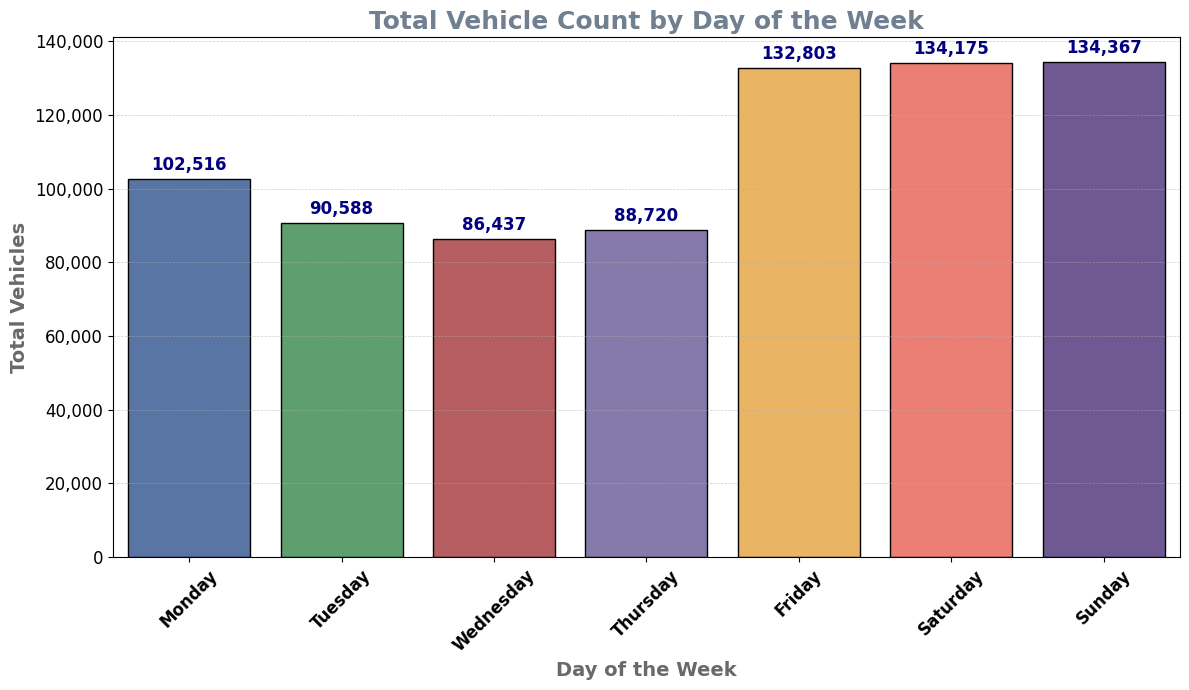

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Define the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group data by day and sum vehicle counts
busiest_days = mobility_df.groupby('DayOfWeek', observed=False)['Vehicle_Count'].sum().reindex(day_order)

# Custom colors for each bar
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#FFB94E', '#FF6F61', '#6B4F9C']

# Plotting
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=busiest_days.index, y=busiest_days.values, palette=colors, edgecolor='black')

# Annotate bars with formatted total vehicle count
for index, value in enumerate(busiest_days.values):
    ax.text(index, value + 0.01 * max(busiest_days.values), f'{int(value):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='navy')

# Titles and axis labels
plt.title("Total Vehicle Count by Day of the Week", fontsize=18, fontweight='bold', color='slategray')
plt.ylabel("Total Vehicles", fontsize=14, fontweight='bold', color='dimgray')
plt.xlabel("Day of the Week", fontsize=14, fontweight='bold', color='dimgray')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Y-axis format with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Improve grid style
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Remove legend if present
legend = ax.get_legend()
if legend:
    legend.remove()

plt.tight_layout()
plt.show()


In [ ]:
mobility_df["Traffic_Condition"].value_counts()

,count
Traffic_Condition,
High,3166
Medium,1475
Low,359


## Impact of Traffic Speed on Traffic Condition

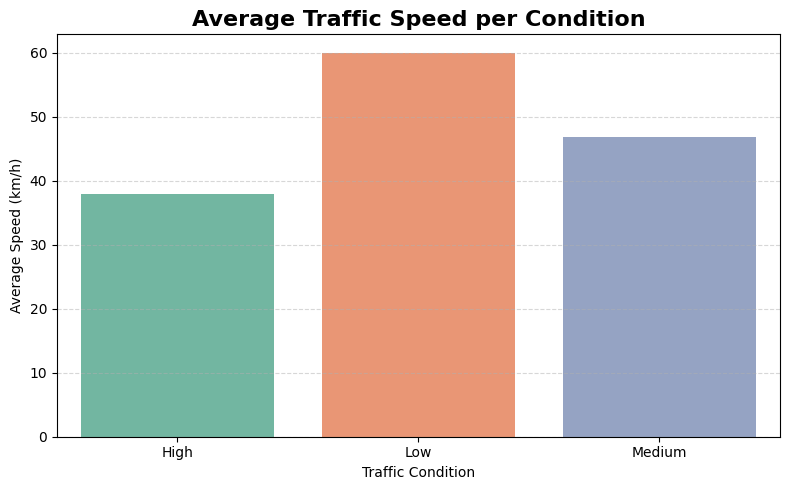

In [ ]:
mean_speed = mobility_df.groupby('Traffic_Condition')['Traffic_Speed_kmh'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=mean_speed,
    x='Traffic_Condition',
    y='Traffic_Speed_kmh',
    palette='Set2',
    hue = 'Traffic_Condition'
)

plt.title('Average Traffic Speed per Condition', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Condition')
plt.ylabel('Average Speed (km/h)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-28-8cd3de853ba9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


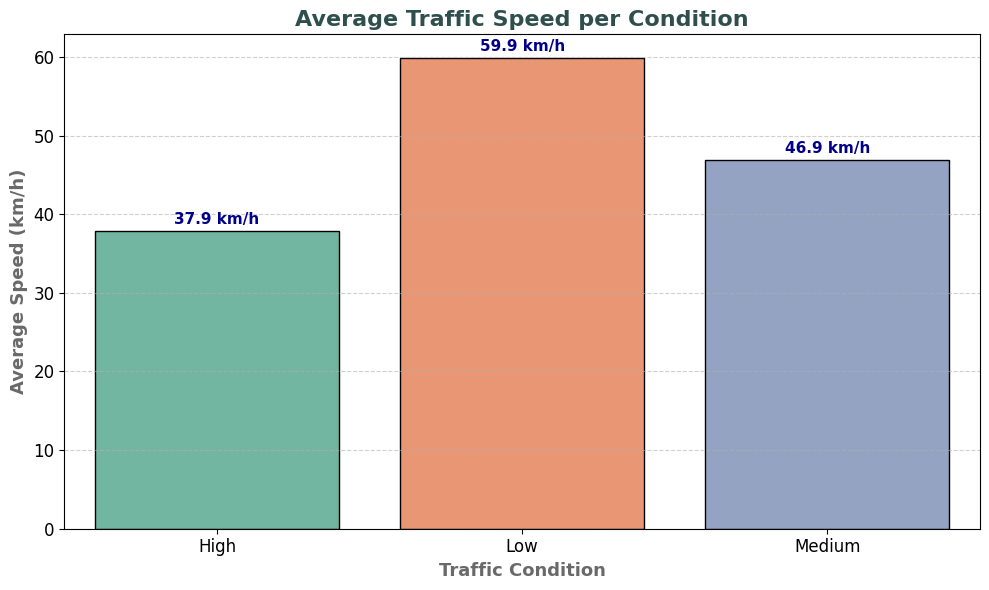

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate mean speed by traffic condition
mean_speed = mobility_df.groupby('Traffic_Condition')['Traffic_Speed_kmh'].mean().reset_index()

# Step 2: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=mean_speed,
    x='Traffic_Condition',
    y='Traffic_Speed_kmh',
    palette='Set2',
    edgecolor='black'
)

# Step 3: Annotate bars with speed values
for i, row in mean_speed.iterrows():
    ax.text(i, row['Traffic_Speed_kmh'] + 0.5, f"{row['Traffic_Speed_kmh']:.1f} km/h",
            ha='center', va='bottom', fontweight='bold', fontsize=11, color='darkblue')

# Plot formatting
plt.title('Average Traffic Speed per Condition', fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel('Traffic Condition', fontsize=13, fontweight='bold', color='dimgray')
plt.ylabel('Average Speed (km/h)', fontsize=13, fontweight='bold', color='dimgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


## Accident Crisis.

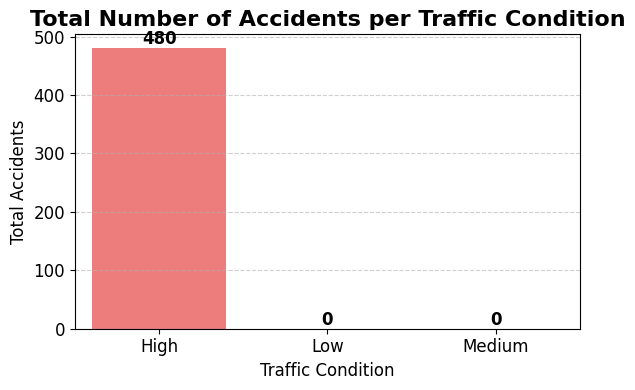

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data: sum of accidents by traffic condition
accidents_by_traffic_condition = mobility_df.groupby('Traffic_Condition')['Accident_Report'].sum().reset_index()

# Sort values (optional, for better visual order)
accidents_by_traffic_condition = accidents_by_traffic_condition.sort_values(by='Accident_Report', ascending=False)

# Plotting
plt.figure(figsize=(6, 4))
colors = ['#FF6B6B', '#FFA36C', '#FFD93D']  # Custom color for each traffic condition
bars = sns.barplot(
    data=accidents_by_traffic_condition,
    x='Traffic_Condition',
    y='Accident_Report',
    palette=colors,
    hue=accidents_by_traffic_condition['Traffic_Condition']
)

# Add count labels on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Styling
plt.title('Total Number of Accidents per Traffic Condition', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Condition', fontsize=12)
plt.ylabel('Total Accidents', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Impact Of Weather condition on Accidents

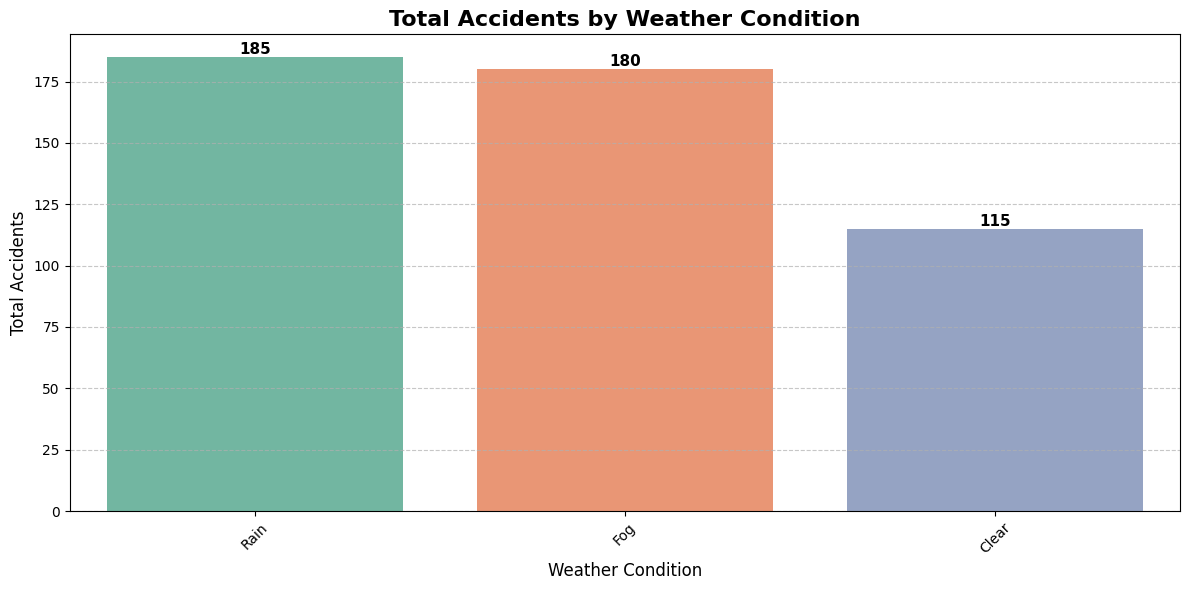

In [ ]:

accidents_weather = mobility_df.groupby('Weather_Condition')['Accident_Report'].sum().reset_index()

accidents_weather = accidents_weather.sort_values(by='Accident_Report', ascending=False)

plt.figure(figsize=(12, 6))
colors = sns.color_palette('Set2', len(accidents_weather))
bars = sns.barplot(
    data=accidents_weather,
    x='Weather_Condition',
    y='Accident_Report',
    palette=colors,
    hue = 'Weather_Condition'
)

for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Total Accidents by Weather Condition', fontsize=16, fontweight='bold')
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Total Accidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
mobility_df["Traffic_Condition"].value_counts().sum()

np.int64(5000)

## Impact of Weather Condition to Traffic Congestion.

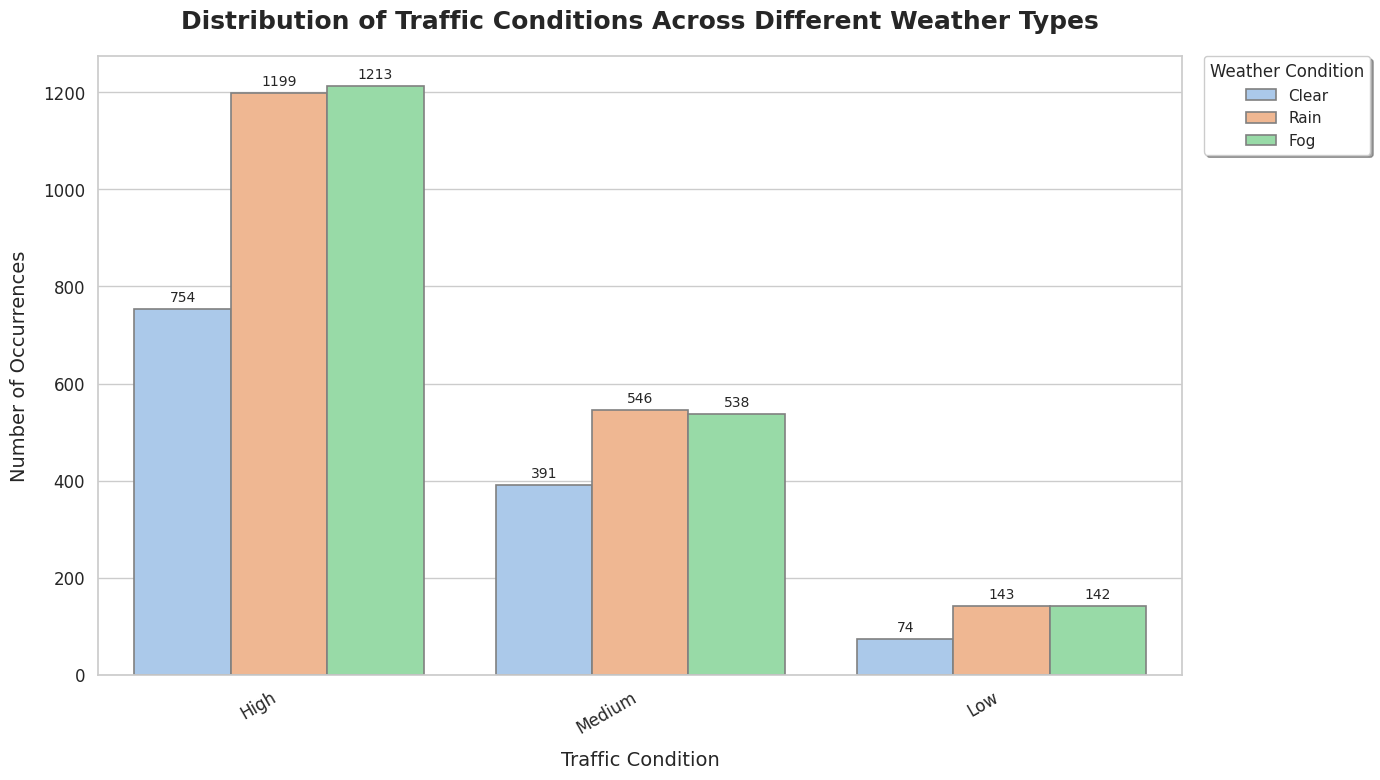

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(14, 8))

order = mobility_df['Traffic_Condition'].value_counts().index
ax = sns.countplot(
    data=mobility_df,
    x='Traffic_Condition',
    hue='Weather_Condition',
    palette='pastel',
    order=order,
    edgecolor='gray',
    linewidth=1.2
)

plt.title('Distribution of Traffic Conditions Across Different Weather Types', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Traffic Condition', fontsize=14, labelpad=10)
plt.ylabel('Number of Occurrences', fontsize=14, labelpad=10)
plt.xticks(rotation=30, ha='right', fontsize=12, fontweight='medium')
plt.yticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)

plt.legend(
    title='Weather Condition',
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True,
    shadow=True
)

plt.tight_layout()
plt.show()

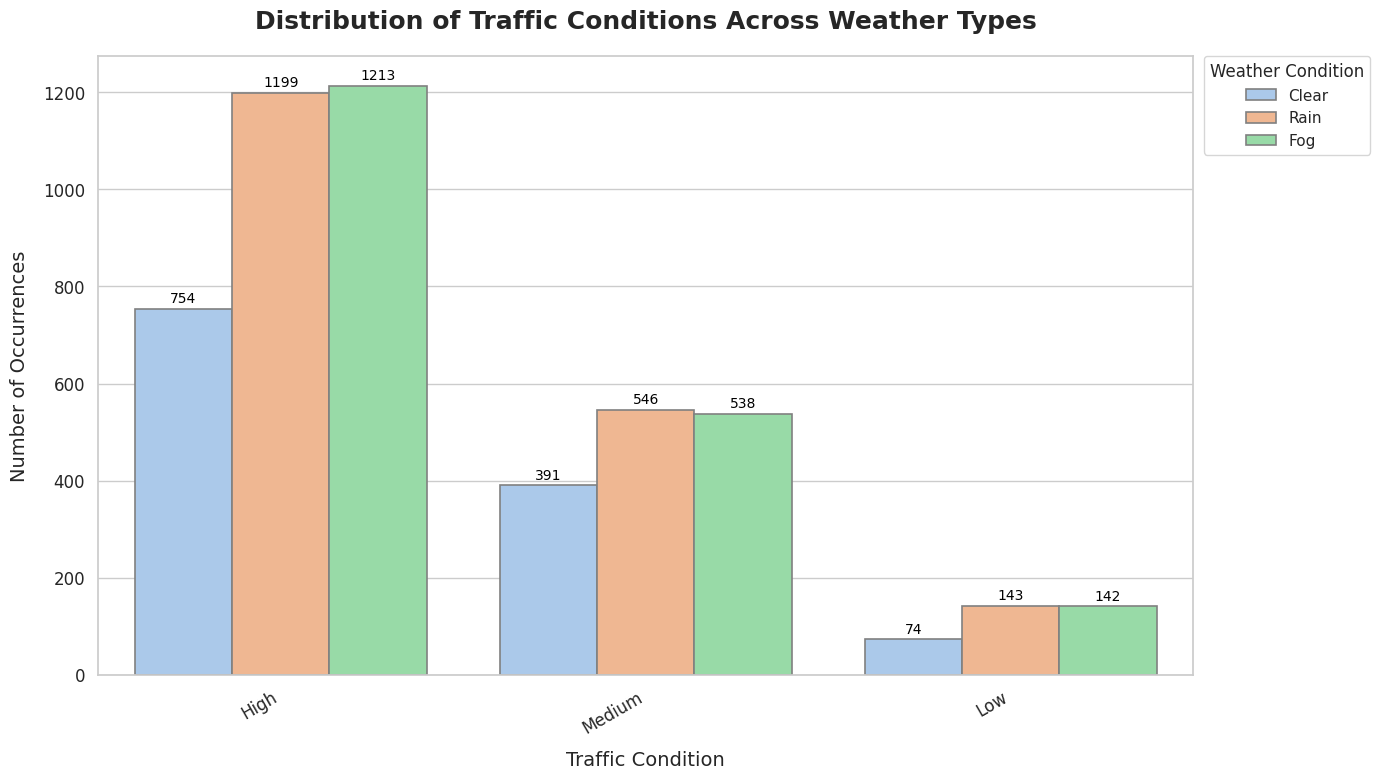

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme and figure size
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(14, 8))

# Sort traffic conditions by frequency
order = mobility_df['Traffic_Condition'].value_counts().index

# Create grouped bar plot
ax = sns.countplot(
    data=mobility_df,
    x='Traffic_Condition',
    hue='Weather_Condition',
    palette='pastel',
    order=order,
    edgecolor='gray',
    linewidth=1.2
)

# Title and labels
plt.title('Distribution of Traffic Conditions Across Weather Types', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Traffic Condition', fontsize=14, labelpad=10)
plt.ylabel('Number of Occurrences', fontsize=14, labelpad=10)
plt.xticks(rotation=30, ha='right', fontsize=12, fontweight='medium')
plt.yticks(fontsize=12)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=10, color='black')

# Improved legend styling
plt.legend(
    title='Weather Condition',
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(1.01, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True,
    shadow=False
)

# Layout optimization
plt.tight_layout()
plt.show()


<ipython-input-34-2dbea639372c>:13: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


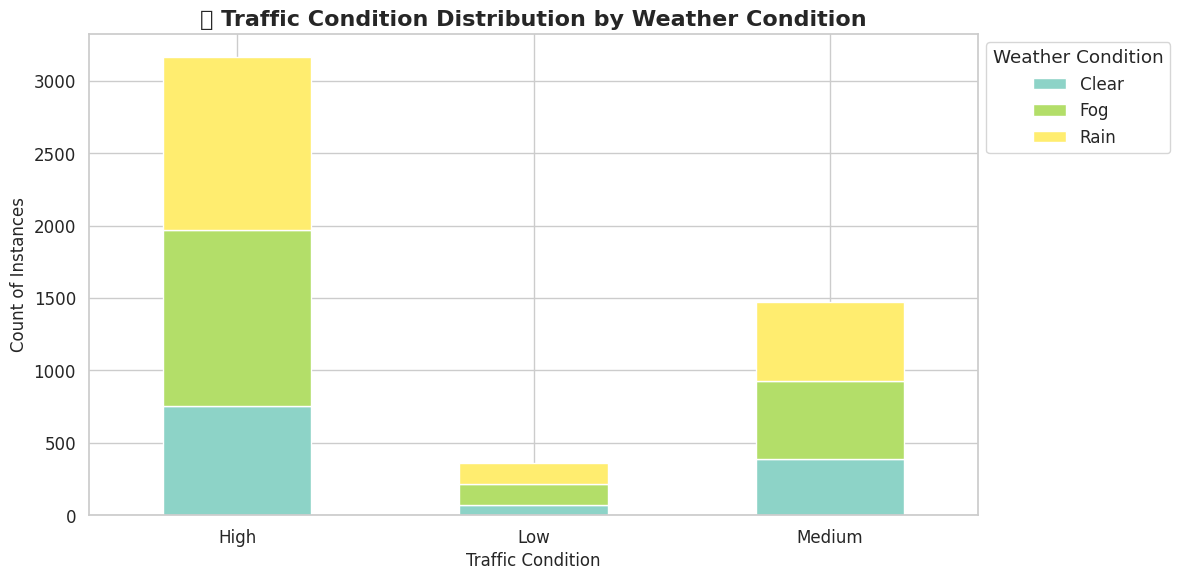

In [ ]:
# Create a crosstab for Traffic Condition vs Weather Condition
traffic_weather_crosstab = pd.crosstab(mobility_df['Traffic_Condition'], mobility_df['Weather_Condition'])

# Plot
traffic_weather_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')

# Styling
plt.title('🌦️ Traffic Condition Distribution by Weather Condition', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Condition', fontsize=12)
plt.ylabel('Count of Instances', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Weather Condition', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
print(mobility_df['Traffic_Condition'].value_counts())

Traffic_Condition
High      3166
Medium    1475
Low        359
Name: count, dtype: int64


# Feature Engineering.

---



## Encoding Categorical Values

In [ ]:
categorical_columns = ['Traffic_Light_State', 'Weather_Condition', 'Traffic_Condition', 'DayOfWeek']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    mobility_df[col] = le.fit_transform(mobility_df[col])
    label_encoders[col] = le

mobility_df[categorical_columns].head(5)


,Traffic_Light_State,Weather_Condition,Traffic_Condition,DayOfWeek
0,2,0,0,0
1,0,0,0,0
2,0,2,0,0
3,1,1,0,0
4,1,1,1,0


In [ ]:
mobility_df.columns

Index(['Timestamp', 'Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%',
       'Traffic_Light_State', 'Weather_Condition', 'Accident_Report',
       'Traffic_Condition', 'Hour', 'DayOfWeek', 'Date'],
      dtype='object')

In [ ]:
X = mobility_df.drop(['Traffic_Condition', 'Timestamp'], axis=1)
y = mobility_df['Traffic_Condition']
X_encoded = pd.get_dummies(X, drop_first=True)
rf = RandomForestClassifier(n_estimators=100 ,random_state=42)
rf.fit(X_encoded, y)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X_encoded.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)
feature_importances

,Importance
Vehicle_Count,0.377890
Road_Occupancy_%,0.242713
Traffic_Speed_kmh,0.231359
Accident_Report,0.077982
Hour,0.025745
Traffic_Light_State,0.008551
Weather_Condition,0.008415
DayOfWeek,0.006071
Date_2024-03-06,0.001551
Date_2024-03-15,0.001510


# Choosing Best Features

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=8)
X_rfe = rfe.fit_transform(X_encoded, y)
selected_features_rfe = X_encoded.columns[rfe.support_]
f"Selected features using RFE: {selected_features_rfe}"

"Selected features using RFE: Index(['Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%',\n       'Traffic_Light_State', 'Weather_Condition', 'Accident_Report', 'Hour',\n       'DayOfWeek'],\n      dtype='object')"

# Model

In [ ]:
mobility_df.columns

Index(['Timestamp', 'Vehicle_Count', 'Traffic_Speed_kmh', 'Road_Occupancy_%',
       'Traffic_Light_State', 'Weather_Condition', 'Accident_Report',
       'Traffic_Condition', 'Hour', 'DayOfWeek', 'Date'],
      dtype='object')

# Train-Test Split

In [ ]:
X = mobility_df.drop(columns=['Traffic_Condition', 'Timestamp' , 'Date'], errors='ignore')
y = mobility_df['Traffic_Condition']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
"Training set:", X_train.shape, y_train.shape
"Test set:", X_test.shape, y_test.shape

('Test set:', (1000, 8), (1000,))

## Resampling The Dataset.

In [ ]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("\nResampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

Original class distribution:
 Traffic_Condition
0    2533
2    1168
1     299
Name: count, dtype: int64

Resampled class distribution:
 Traffic_Condition
2    2533
0    2533
1    2533
Name: count, dtype: int64


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

# Making Predictions

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_decoded = label_encoders['Traffic_Condition'].inverse_transform(y_test)
y_pred_decoded = label_encoders['Traffic_Condition'].inverse_transform(y_pred)

In [ ]:
# Make predictions on the resampled training data
y_train_pred = model.predict(X_train_resampled)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Accuracy on Training Data:", accuracy)
print("\nClassification Report for Training Data:")
print(classification_report(y_train_resampled, y_train_pred))

Accuracy on Training Data: 0.9619686800894854

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2533
           1       0.97      1.00      0.99      2533
           2       0.92      0.98      0.95      2533

    accuracy                           0.96      7599
   macro avg       0.96      0.96      0.96      7599
weighted avg       0.96      0.96      0.96      7599



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       633
           1       0.70      0.97      0.81        60
           2       0.82      0.91      0.86       307

    accuracy                           0.90      1000
   macro avg       0.83      0.92      0.87      1000
weighted avg       0.91      0.90      0.90      1000



# Using Confusion Matrix

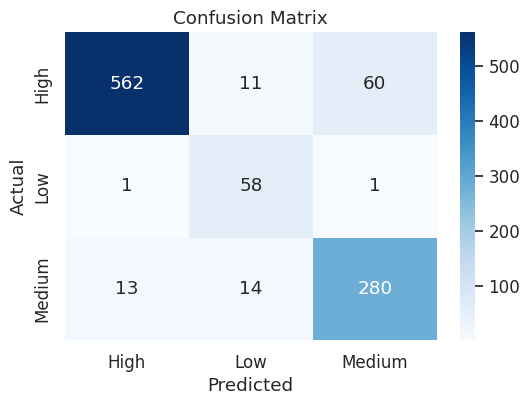

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class names from the label encoder
class_names = label_encoders['Traffic_Condition'].classes_

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model and parameters
best_knn_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

# Evaluate on test data
y_pred = best_knn_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters:
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.907

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       633
           1       0.75      0.97      0.85        60
           2       0.84      0.90      0.87       307

    accuracy                           0.91      1000
   macro avg       0.85      0.92      0.88      1000
weighted avg       0.91      0.91      0.91      1000



# Model Evaluation

## Cross Validation.

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.907 0.909 0.898 0.895 0.904]
Mean CV Accuracy: 0.9026


## Class distributions

In [ ]:
print(y_train.value_counts(normalize=True))

Traffic_Condition
0    0.63325
2    0.29200
1    0.07475
Name: proportion, dtype: float64


## Save the Model

In [ ]:
# Save model and encoders
import joblib

joblib.dump(model, 'traffic_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(X_train.columns.tolist(), 'feature_columns.pkl')

['feature_columns.pkl']

In [ ]:
import pandas as pd
import joblib
import numpy as np

# Load model and encoders
model = joblib.load('traffic_model.pkl')
label_encoders = joblib.load('label_encoders.pkl')
feature_columns = joblib.load('feature_columns.pkl')

# New input data
new_data = pd.DataFrame({
    'Vehicle_Count': [101],
    'Traffic_Speed_kmh': [100.2],
    'Road_Occupancy_%': [1.0],
    'Traffic_Light_State': ['Green'],
    'Weather_Condition': ['Fog'],
    'Accident_Report': [0],
    'Hour': [2],
    'DayOfWeek': ['Monday']
})

# Safely encode categorical features
for column, le in label_encoders.items():
    if column in new_data.columns:
        # Fill unseen values with -1
        new_data[column] = new_data[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Reorder columns as expected by the model
new_data = new_data[feature_columns]

# Predict
prediction = model.predict(new_data)

# Decode the prediction
result = label_encoders['Traffic_Condition'].inverse_transform(prediction)
print("Predicted Traffic Condition:", result[0])


Predicted Traffic Condition: Medium


In [ ]:
print("Final Input to Model:\n", new_data)


Final Input to Model:
    Vehicle_Count  Traffic_Speed_kmh  Road_Occupancy_%  Traffic_Light_State  \
0            101              100.2               1.0                    0   

   Weather_Condition  Accident_Report  Hour  DayOfWeek  
0                  1                0     2          1  


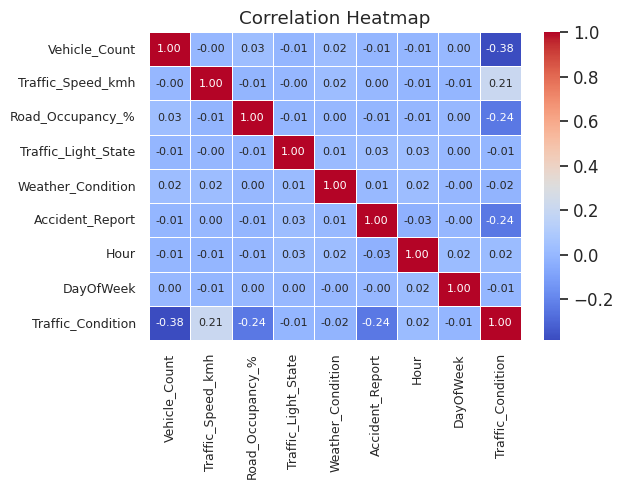

In [ ]:
target_col = 'Traffic_Condition'
cols = [col for col in mobility_df.columns if col != target_col] + [target_col]

# Reorder the DataFrame
mobility_df_reordered = mobility_df[cols]

# Compute the correlation matrix
correlation_matrix = mobility_df_reordered.corr(numeric_only=True)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})

plt.title("Correlation Heatmap")
plt.show()